# 2. CLASSIFICATORE LINEARE SVM CON INPUT DI N-GRAMMI

Classificatore basato su  SVM che prende in input una matrice di features basata su n-grammi di 3 tipi:
1. Caratteri
2. Token
3. Part of Speech

***

### Preprocessing dei dati

Dobbiamo ottenere un vettore di features, basato sulle occorrenze di n-grammi all'interno delle frasi, per ciascun post. Come prima cosa si crea si per training che per test un set formato da liste di dizionari. I dizionari riportano per ogni token 3 campi che corrispondono alla parola, la forma lemmatizzata e la parte del discorso. Infine contiamo all'interno dei post le occorrenze degli n-grammi. Una volta ottenuti tutti gli n-grammi possiamo creare la matrice di occorrenze. 

In [2]:
import pandas as pd
import os

In [3]:
#creiamo un dizionario che abbia 3 campi: word, lemma e part of speech(pos)
def create_set(type):
    annotated_posts = []
    for doc in os.listdir("../data/UD_annotation"):
        if type in doc: 
            doc_tokens = []
            doc_path = "../data/UD_annotation/" + doc
            for line in open(doc_path, "r", encoding="utf-8"):
                splitted = line.strip().split("\t")
                if splitted[0].isdigit() and "-" not in splitted[0]:
                    word=splitted[1]
                    lemma=splitted[2]
                    pos=splitted[3]
                    new_token = {'word': word, 'lemma': lemma, 'pos': pos}
                    doc_tokens.append(new_token)
            annotated_posts.append(doc_tokens)
    return annotated_posts

annotation_tr = create_set("training")
annotation_ts = create_set("test")


In [4]:
#funzione che estrae le labels dal nome del file
def create_labels(type):
    labels_irony = []
    labels_sarcasm = []
    for doc in os.listdir("../data/UD_annotation"):
        if type in doc: 
            splitted = doc.split("#")
            irony = splitted[2]
            sarcasm = splitted[3]
            labels_irony.append(irony)
            labels_sarcasm.append(sarcasm)
    return labels_irony, labels_sarcasm
        

In [5]:
#contiamo il numero di post(sample) per training e test
print(f'Training: {len(annotation_tr)}')
print(f'Test: {len(annotation_ts)}')

Training: 3977
Test: 872


In [6]:
#funzione che conta le occorrenze degli ngrammi all'interno di un post
def count_ngrams(post, ft_type, n, char=False):
    all_ngrams = {}
    allwords = []
    if not char:
        for word in post:
            allwords.append(word[ft_type])
        post_length = len(allwords)
    else:
        for word in post:
            allwords.append(word['word'])
        allwords = " ".join(allwords)
        post_length = len(allwords)-1
    for i in range(len(allwords)-(n-1)):
        new_ngram = allwords[i:i+n]
        if not char:
            ngram_id = f'{ft_type}_{n}_'+'_'.join(new_ngram)
        else:
            ngram_id = f'char_{n}_'+'_'.join(new_ngram)
        if ngram_id not in all_ngrams:
            all_ngrams[ngram_id] = 1
        else:
            all_ngrams[ngram_id]+=1
    #normalizzare in base alla post_length
    for ngram in all_ngrams:
        all_ngrams[ngram] = all_ngrams[ngram]/post_length
    return all_ngrams

print(count_ngrams(annotation_tr[2], "word", 2, False))



{'word_2_#la7_ma': 0.05555555555555555, 'word_2_ma_perche': 0.05555555555555555, "word_2_perche_'": 0.05555555555555555, "word_2_'_Mario": 0.05555555555555555, 'word_2_Mario_Monti': 0.05555555555555555, 'word_2_Monti_non': 0.05555555555555555, 'word_2_non_fa': 0.05555555555555555, 'word_2_fa_il': 0.05555555555555555, 'word_2_il_premier': 0.05555555555555555, 'word_2_premier_?': 0.05555555555555555, 'word_2_?_Che': 0.05555555555555555, 'word_2_Che_persona': 0.05555555555555555, 'word_2_persona_competente': 0.05555555555555555, 'word_2_competente_e': 0.05555555555555555, 'word_2_e_per': 0.05555555555555555, 'word_2_per_bene': 0.05555555555555555, 'word_2_bene_!': 0.05555555555555555}


Uniamo per ogni tipo di informazione che vogliamo i relativi dizionari, così da avere un dizionario denso di informazioni. 


In [7]:
#funzione che unisce per ogni post i diversi tipi di n-grammi
def get_features(dataset, info_types):
    all_features = []
    for post in dataset: 
        complete_dict = dict()
        for info in info_types:
            info_dict = count_ngrams(post, info[0], info[1], info[2])
            complete_dict = complete_dict | info_dict
        all_features.append(complete_dict)
    return all_features

#per cambiare tipo di info cambiare questi parametri
infos = [['word', 1, False], ['word', 2, False], ['word', 1, True], ['word', 2, True]]
info_description = f'unigrammi parole; bigrammi parole; unigrammi caratteri; bigrammi caratteri;'

tr_features = get_features(annotation_tr, infos)
ts_features = get_features(annotation_ts, infos)

print(tr_features[1])
    
        

{'word_1_Mario': 0.043478260869565216, 'word_1_Monti': 0.043478260869565216, 'word_1_:': 0.043478260869565216, "word_1_c'": 0.043478260869565216, 'word_1_è': 0.043478260869565216, 'word_1_il': 0.043478260869565216, 'word_1_rischio...': 0.043478260869565216, 'word_1_di': 0.08695652173913043, 'word_1_trasformare': 0.043478260869565216, "word_1_l'": 0.08695652173913043, 'word_1_Italia': 0.043478260869565216, 'word_1_da': 0.043478260869565216, 'word_1_Stato': 0.08695652173913043, 'word_1_fondatore': 0.043478260869565216, 'word_1_in': 0.043478260869565216, 'word_1_affondatore': 0.043478260869565216, 'word_1_Unione': 0.043478260869565216, 'word_1_europea': 0.043478260869565216, 'word_1_!': 0.043478260869565216, 'word_1_<URL>': 0.043478260869565216, 'word_2_Mario_Monti': 0.043478260869565216, 'word_2_Monti_:': 0.043478260869565216, "word_2_:_c'": 0.043478260869565216, "word_2_c'_è": 0.043478260869565216, 'word_2_è_il': 0.043478260869565216, 'word_2_il_rischio...': 0.043478260869565216, 'word_

Per ridurre la dimensionalità della nostra matrice, eliminiamo gli n-grammi che occorrono in un numero di documenti sotto una soglia.

In [8]:
#funzione che estrae la lista di feature presenti all'interno del dataset
def get_feature_list(feature_set):
    feature_list = []
    for post in feature_set:
        for feature in post:
            if feature not in feature_list:
                feature_list.append(feature)
    return feature_list

In [9]:
all_features = get_feature_list(tr_features)

In [10]:
#funzione che ritorna True se le occorrenze sono al di sopra di un valore soglia, e False altrimenti
def is_common(feature, feature_set, min_occurrences):
    count = 0
    for post in feature_set:
        if feature in post:
            count += 1
    if count < min_occurrences:
        return False
    else:
        return True

#passiamo la funzione is_common come parametro di filter, così facendo si ottiene una nuova lista di features con solo le features più comuni  
filtered_features = list(filter(lambda x: is_common(x, tr_features, 3), all_features))
print(f'Numero di features prima del filtro: {len(all_features)}')
print(f'Numero di features dopo il filtro: {len(filtered_features)}')

Numero di features prima del filtro: 64468
Numero di features dopo il filtro: 7534


In [11]:
def filter_dataset(dataset, features_tokeep):
    for post in dataset:
        post_features = list(post.keys())
        for feature in post_features:
            if feature not in features_tokeep:
                post.pop(feature)
    return dataset


print(f'Numero di features per sample non filtrato: {len(tr_features[10])}')
tr_features = filter_dataset(tr_features, filtered_features)
print(f'Numero di features in un sample filtrato: {len(tr_features[10])}')


Numero di features per sample non filtrato: 135
Numero di features in un sample filtrato: 125


In [12]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.svm import LinearSVC




vectorizer = DictVectorizer()
tr_set = vectorizer.fit_transform(tr_features)
scaler = MaxAbsScaler()
tr_set = scaler.fit_transform(tr_set)
tr_labels_irony, tr_labels_sarcasm = create_labels("training")


### Training

In [13]:
svc = LinearSVC(dual=True, max_iter=10000)
svc.fit(tr_set, tr_labels_irony)


LinearSVC(max_iter=10000)

### Validation con diversi tipi di informazione

In [14]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.dummy import DummyClassifier
import numpy as np

In [15]:
splitter = KFold(n_splits=5, random_state=42, shuffle=True)
folds = list(splitter.split(tr_set))

tr_labels = np.asarray(tr_labels_irony)
i=1
real_lbls = []
predicted = []
all_acc = []
all_dummy_acc = []

for fold in folds:
    print(f'-------------------------Fold n.{i} just started!-------------------------')
    #si creano i set per ogni fold, training e test
    train_index = fold[0]
    test_index = fold[1]
    #train set
    x_train = tr_set[train_index]
    y_train = tr_labels[train_index]
    #test set
    x_test = tr_set[test_index]
    y_test = tr_labels[test_index]
    #inizio del training
    ksvc = LinearSVC(dual=False)
    ksvc.fit(x_train, y_train)
    #predictions
    pred = ksvc.predict(x_test)
    acc = accuracy_score(y_test, pred)
    #usiamo un Dummy Classifier come Baseline
    dummy = DummyClassifier(strategy="most_frequent")
    dummy.fit(x_train, y_train)
    dummy_acc = dummy.score(x_test, y_test)
    real_lbls+=y_test.tolist()
    predicted+=pred.tolist()
    all_acc.append(acc)
    all_dummy_acc.append(dummy_acc)
    print("---> test: ")
    print(f"Accuracy del modello: {acc}\nAccuracy della baseline: {dummy_acc}")
    i+=1


def avg(x):
    return sum(x)/len(x)

'''
with open('results.txt', 'a') as file:
    file.write(f'{info_description}\n')
    for i in range(len(all_acc)):
        file.write(f'Risultati Fold {i+1} -->  Accuracy modello: {all_acc[i]} | Accuracy baseline: {all_dummy_acc[i]}  \n')
    file.write(f'Media: {avg(all_acc)}')
'''

-------------------------Fold n.1 just started!-------------------------
---> test: 
Accuracy del modello: 0.6846733668341709
Accuracy della baseline: 0.5062814070351759
-------------------------Fold n.2 just started!-------------------------
---> test: 
Accuracy del modello: 0.6959798994974874
Accuracy della baseline: 0.45226130653266333
-------------------------Fold n.3 just started!-------------------------
---> test: 
Accuracy del modello: 0.6981132075471698
Accuracy della baseline: 0.5031446540880503
-------------------------Fold n.4 just started!-------------------------
---> test: 
Accuracy del modello: 0.70062893081761
Accuracy della baseline: 0.47924528301886793
-------------------------Fold n.5 just started!-------------------------
---> test: 
Accuracy del modello: 0.6918238993710691
Accuracy della baseline: 0.5069182389937107


"\nwith open('results.txt', 'a') as file:\n    file.write(f'{info_description}\n')\n    for i in range(len(all_acc)):\n        file.write(f'Risultati Fold {i+1} -->  Accuracy modello: {all_acc[i]} | Accuracy baseline: {all_dummy_acc[i]}  \n')\n    file.write(f'Media: {avg(all_acc)}')\n"

### Test

Una volta ottenuta la configurazione di input migliore (con accuratezza più alta), si procede a testare il modello con l'input che ha avuto le migliori prestazioni. In questo caso si tratta di unigrammi e bigrammi di caratteri e unigrammi e bigrammi di parole. 

In [16]:
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [17]:
#ts_set = filter_dataset(ts_features, filtered_features)
ts_set = vectorizer.transform(ts_features)
ts_set = scaler.transform(ts_set)
ts_labels_irony, ts_labels_sarcasm = create_labels("test")
ts_labels = ts_labels_irony


In [18]:
test_preds = ksvc.predict(ts_set)
print(classification_report(ts_labels, test_preds, zero_division=0))

              precision    recall  f1-score   support

           0       0.68      0.59      0.64       437
           1       0.64      0.72      0.68       435

    accuracy                           0.66       872
   macro avg       0.66      0.66      0.66       872
weighted avg       0.66      0.66      0.66       872



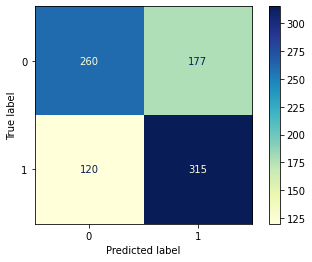

In [19]:
ConfusionMatrixDisplay.from_predictions(ts_labels, test_preds, cmap="YlGnBu")